In [20]:
import ray
import torch
import matplotlib.pyplot as plt
import random
import numpy as np

from runner import ModelRunner
from env.static_env import TA_Static
from utils import load_train_config, load_ray_config, save_configs

In [21]:
class Sampler(object):
    def __init__(self, cfg, decode_type='sampling'):
        self.cfg = cfg
        self.device = self.cfg["device"]

        self.model = ModelRunner(self.cfg)
        self.model.to(self.device)

        self.reward_buffer = []
        self.max_length_buffer = []
        self.total_reward_buffer = []
        self.baseline_buffer = []
        self.episode_buffer = []
        for i in range(5):
            self.episode_buffer.append([])

        self.decode_type = decode_type

    def sample(self, env):
        self.env = env
        with torch.no_grad():
            route_set, reward, total_reward, max_length_ngative, max_length, max_id, episode_buffer = self.model(self.env)
        
        self.route_set = route_set
        self.reward_buffer += reward
        self.total_reward_buffer.append(total_reward)
        self.max_length_buffer.append(max_length)
        
        for i in range(5):
            self.episode_buffer[i] += episode_buffer[i]
            
    def plot(self):
        # print(self.route_set)
        # Unpack information
        vehicle_info = self.env.vehicle_initial
        task_info = self.env.task
        vehicle_amount = self.env.vehicle_total_num
        task_amount = self.env.task_total_num
        
        fig, ax = plt.subplots()
        
        ax.set_title(config_name)
        ax.set_xlim((-0.1,1.1))
        ax.set_ylim((-0.1,1.1))
        ax.set_aspect("equal")
        
        
        task_colors = ["k","m","c"]
        for i, (t_type_name, t_info) in enumerate(task_info.items()):
            ax.scatter(task_info[t_type_name]["position"][0][:,0],task_info[t_type_name]["position"][0][:,1],
                       marker='x', s=25,  facecolor=task_colors[i], label=t_type_name)
        
        
        colors = iter([plt.cm.Set1(i) for i in range(vehicle_amount+1)])
        vehicle_color = dict()
        vehicle_scatters = []
        vehicle_markers = ['^','s','o']
        for i, (v_type_name, v_info) in enumerate(vehicle_info.items()):
            vehicle_color[v_type_name]=next(colors)
            vehicle_depot = v_info["position"]

            ax.scatter(vehicle_depot[0][:,0], vehicle_depot[0][:,1], marker='*', s=80, facecolor=vehicle_color[v_type_name])
            
            for j in range(v_info["num"]):
                target_set = np.concatenate((vehicle_depot, task_info["visit"]["position"]), axis=1)
                route = list(filter(lambda x: x>0, self.route_set[v_type_name][j]))
                route.insert(0,0)
                # print(target_set)
                # print(route)
                if j == 0:
                    ax.plot(target_set[0][route,0],target_set[0][route,1],
                            color = vehicle_color[v_type_name],
                            linestyle = ':')
                    ax.scatter(target_set[0][route[-1],0],target_set[0][route[-1],1],
                               marker=vehicle_markers[i],s=80, facecolors=vehicle_color[v_type_name], label=v_type_name)
                else:
                    ax.plot(target_set[route][:,0],target_set[route][:,1],
                            color = vehicle_color[v_type_name],
                            linestyle = ':')
                    ax.scatter(target_set[0][route[-1],0],target_set[0][route[-1],1],
                               marker=vehicle_markers[i],s=80, facecolors=vehicle_color[v_type_name])
        
        ax.legend()

In [22]:
config_name = "simple"
cfg = load_train_config(config_name)
cfg["device"] = "cpu"

checkpoint = torch.load('model_save/simple/exp_1.pth')

sampler = Sampler(cfg)
sampler.model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

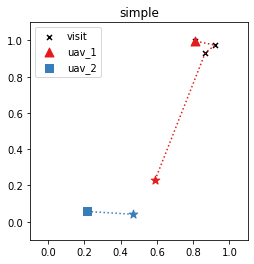

In [48]:
seed = random.randint(0, 1000)
env = TA_Static(cfg, seed)
env.reset()

sampler.sample(env)
sampler.plot()